In [2]:
from functions import *
from datetime import datetime
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,OneHotEncoderEstimator,QuantileDiscretizer, StringIndexer, Imputer,StandardScaler,MinMaxScaler
from pyspark.sql.functions import udf
from pyspark.ml.linalg import SparseVector, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.feature import ChiSqSelector,PCA
from pyspark.sql.types import DoubleType

from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator

In [3]:
model_indexing_dir = "log_index.md"
images_dir = "analysis"
models_dir = "models"
logs_dir = "models" 
filter_state = 'TX' # ALL if all states
model_Note = ''
log_mode=True # Logs data to files, Dont use on massive dataset (debug_mode is recommended while on)
debug_mode=False # Reduce number of rows collected for faster processing
enable_plots = True # Dont use unless debug_mode is on, or datasize is small
logger = logging(models_dir, logs_dir, images_dir, filter_state, enabled=log_mode)

file = "data/US_Accidents_Dec19.csv"


df, sc,spark = setup_spark(file)

In [4]:
sc

<SparkContext master=local[*] appName=Spark Project>

In [5]:
tmp = sc._conf.getAll()
logger.write2file("New Spark session", str(tmp))
print("Config:",tmp)

Config: [('spark.driver.port', '44459'), ('spark.driver.memory', '4g'), ('spark.executor.memory', '4g'), ('spark.driver.host', '4082e07eadd9'), ('spark.ui.enabled', 'true'), ('spark.executor.id', 'driver'), ('spark.app.name', 'Spark Project'), ('spark.ui.killEnabled', 'false'), ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'), ('spark.app.id', 'local-1589839392160'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.executor.cores', '1'), ('spark.submit.deployMode', 'client'), ('spark.kryoserializer.buffer.max', '15'), ('spark.ui.showConsoleProgress', 'true'), ('spark.driver.cores', '1')]


# Debug tool

In [6]:
if debug_mode == True: 
    df.createOrReplaceTempView("records")
    reviewData = spark.sql("SELECT * FROM records LIMIT 100000") 

df.count()

2925212

# Define Columns

In [7]:
colLabel = ["Severity"]

colRem = ['ID', 
          'Source',
          'End_Time',
          'End_Lat',
          'End_Lng',
          'Description',
        ]

df, colCat, colNum = setup_variables(df, sc, colLabel, colRem)  

logger.write2file("Number of rows", str(df.count()))
logger.write2file("Categorical groups","Defined Label:\n" + str(colLabel) + "\nDefined Categories:\n" + str(colCat) + "\nDefined Numerical:\n" +str(colNum))

Label: ['Severity'] 
Categories: ['Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
Numerical: ['TMC', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Number', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']


# 2. Preprocessing

## Analyse single state
#Create a model for separates states instead of all states at once.

In [8]:
if filter_state != 'ALL':
    df = df.filter(df.State == filter_state) # Lowers the dataset quite a lot
    logger.write2file("Specified state",str(filter_state))
else:
    logger.write2file("No state specified","")

## Modify time
#Convert the timestamp into a numeric value and then into a string so that the time of day and month can be categorised.

In [9]:
# Convert to int then cast to string

df = df.withColumn('Start_Hour', hour(to_timestamp(from_utc_timestamp(df['Start_Time'], df['Timezone']).cast('string'), 'yyyy-MM-dd HH:mm:ss')))
df = df.withColumn('Start_Month', month(to_timestamp(from_utc_timestamp(df['Start_Time'], df['Timezone']).cast('string'), 'yyyy-MM-dd HH:mm:ss')))

df = df.withColumn('Weather_Hour', hour(to_timestamp(from_utc_timestamp(df['Weather_Timestamp'], df['Timezone']).cast('string'), 'yyyy-MM-dd HH:mm:ss')))
df = df.withColumn('Weather_Month', month(to_timestamp(from_utc_timestamp(df['Weather_Timestamp'], df['Timezone']).cast('string'), 'yyyy-MM-dd HH:mm:ss')))

df.show(1)
logger.write2file("Dataset after modifying UTC timestamp", str(df.take(1)))

+-----+--------+-------------------+---------+----------+------------+------+------------+----+------+------+-----+-------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+-----------+------------+-------------+
|  TMC|Severity|         Start_Time|Start_Lat| Start_Lng|Distance(mi)|Number|      Street|Side|  City|County|State|Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunri

## Cluster quantiles to reduce the feature vector for position
#Since feature crossing wont work due to the feature vector is to big (regarding to the given resources) we hope that Clustering might reduce them and keep as much data as possible

In [10]:
pos_assembler = VectorAssembler(inputCols=['Start_Lat', 'Start_Lng'], outputCol="position_features")
pos_scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="position_features", outputCol="position_scaledFeatures")

pos_pipeline = Pipeline(stages=[pos_assembler, pos_scaler])
cord_model = pos_pipeline.fit(df)
preprocessed_cord = cord_model.transform(df)
logger.write2fileModel(cord_model, "position_Model")

trainSet, testSet = preprocessed_cord.randomSplit([0.9 ,0.1], 1)

Saving into: models/TX_20200518220306/position_Model
'function' object has no attribute 'format'
Saving through format 2


Clustering k: 398 Cost: 0.18897489727685535
Clustering k: 399 Cost: 0.18305237707606667


AttributeError: 'AxesSubplot' object has no attribute 'savefig'

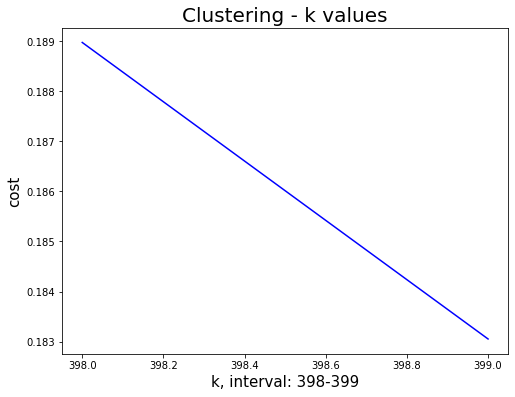

In [11]:
# Test different k for clustering
if enable_plots:
    k_interval = (398,399)
    cost = [0] * (k_interval[1]-k_interval[0]+1)
    for k in range(k_interval[0],k_interval[1]+1):
        kmeans = KMeans(k=k,seed=1, featuresCol='position_scaledFeatures', predictionCol='cluster_position')
        model = kmeans.fit(trainSet)
        k_cost = model.computeCost(testSet)
        cost[k-k_interval[0]] = k_cost
        print("Clustering","k: "+ str(k)+  " Cost: " + str(k_cost))
        logger.write2file("Clustering","k: "+ str(k)+  " Cost: " + str(k_cost))
        
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    b = sns.lineplot(range(k_interval[0],k_interval[1]+1),cost, color='blue')
    b.axes.set_title("Clustering - k values",fontsize=20)
    b.set_xlabel('k, interval: ' + str(k_interval[0]) + '-' + str(k_interval[1]),fontsize=15)
    b.set_ylabel('cost',fontsize=15)
    b.tick_params(labelsize=10) 

    logger.saveImage(b,"Clustering_k_values")

In [ ]:
# Test the model with actual numbers
number_of_clusters= 400

kmeans = KMeans(k=number_of_clusters, featuresCol='position_scaledFeatures', predictionCol='cluster_position')
cluster_model = kmeans.fit(trainSet)
predictions = cluster_model.transform(testSet)

evaluator = ClusteringEvaluator(featuresCol='position_scaledFeatures', predictionCol='cluster_position')

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Transform the hole dataset
df = cluster_model.transform(preprocessed_cord)
df.select('Start_Lat','Start_Lng','position_scaledFeatures','cluster_position').show(5,False)

logger.write2fileModel(cluster_model, "Cluster_Model")

In [ ]:
# Display the different clusters based on the final clustering model
if enable_plots:
    
    tmp_df_pos = df.select('position_scaledFeatures', 'cluster_position')
    # Split coordinates
    tmp_df_pos = tmp_df_pos.withColumn("x", udf(lambda c: float(c[0]), DoubleType())('position_scaledFeatures'))
    tmp_df_pos = tmp_df_pos.withColumn("y", udf(lambda c: float(c[1]), DoubleType())('position_scaledFeatures'))
    tmp_df_pos.show(5)
    pd_df_pos = tmp_df_pos.toPandas()
    
    fig, ax = plt.subplots(1,1, figsize =(12,10))
    
    b = sns.scatterplot(x="x", y="y", hue="cluster_position", data=pd_df_pos,palette="Paired",legend=None)
    b.axes.set_title("Clustering model",fontsize=20)
    b.set_xlabel('Longitude',fontsize=15)
    b.set_ylabel('Latitude',fontsize=15)
    b.tick_params(labelsize=10) 
    plt.gca().legend().set_title('')
    
    logger.saveImage(b,"Clustering_centroids")

In [ ]:
df.show(1)
logger.write2file("Dataset after adding quantiles",str(df.take(1)))

## Cast data 
#Cast all the datacolumns into correct format so they will be sorted to numerical or categorical values. Data removed caused to big feature vector, contained too #many NaN values or were converted into another form.

In [ ]:
# Could be handles as separated lists and then sent to a UDF for processing but since low number of features and easier to visualize this select is kept.
df = df.select(
        col('Severity').cast('int'),
        col('Start_Hour').cast('string'),
        col('Start_Month').cast('string'),
        col('Weather_Hour').cast('string'),
        col('Weather_Month').cast('string'),
        col('cluster_position').cast('string'),
        col('Distance(mi)').cast('double'),
        col('Side').cast('string'),   
        col('Temperature(F)').cast('double'),
        col('Wind_Chill(F)').cast('double'), 
        col('Humidity(%)').cast('double'),
        col('Pressure(in)').cast('double'),
        col('Visibility(mi)').cast('double'),
        col('Wind_Direction').cast('string'),
        col('Wind_Speed(mph)').cast('double'), 
        col('Weather_Condition').cast('string'),
        col('Amenity').cast('string'),
        col('Bump').cast('string'),
        col('Crossing').cast('string'),
        col('Give_Way').cast('string'),
        col('Junction').cast('string'),
        col('No_Exit').cast('string'),
        col('Railway').cast('string'),
        col('Roundabout').cast('string'),
        col('Station').cast('string'),
        col('Stop').cast('string'),
        col('Traffic_Calming').cast('string'),
        col('Traffic_Signal').cast('string'),
        col('Turning_Loop').cast('string'),
        col('Sunrise_Sunset').cast('string'),
        col('Civil_Twilight').cast('string'),
        col('Nautical_Twilight').cast('string'),
        col('Astronomical_Twilight').cast('string')
    ) 

colLabel = ["Severity"]

colCat, colNum = createNewClasses(df, sc, colLabel)
logger.write2file("Categorical groups","Defined Label:\n" + str(colLabel) + "\nDefined Categories:\n" + str(colCat) + "\nDefined Numerical:\n" +str(colNum))

## Get categorical values

In [ ]:
df.persist()
tmp = [df.select(countDistinct(c).alias(c)).collect()[0] for c in [*colCat]] 
df.unpersist()
print("Unique column values:", tmp)

logger.write2file("Unique column values", str(tmp))

## Clean data

### Recheck the missing values
#Check so that the output contains 0 missing values

In [ ]:
df.persist()
printMissingValues(df,logger)
df.unpersist()

### Remove data with occurance less than 1%
#Based on information from analysis. With further analysis lower procentage can be used to find better results.

In [ ]:
df.persist()
original_rows = df.count()
n = int(df.count()*0.001) # Limit the plot to ignore conditions below an limit

weather_freq = df.groupBy('Weather_Condition').count().orderBy('count',ascending=False)
df_filtered = weather_freq.filter(weather_freq['count'] > n)
filtered_conditions = df_filtered.select("Weather_Condition").rdd.flatMap(lambda x: x).collect()
df = df.filter(df['Weather_Condition'].isin(*filtered_conditions))

df_filtered.show()
removed_rows = original_rows - df.count()

df.unpersist()
print("Rows removed:",removed_rows)

logger.write2file("Weather condition", str(df_filtered.take(df_filtered.count())) + "\nRows removed: " + str(removed_rows))

# Remove if distict values in category equals 1

In [ ]:
df.persist()
tmp = [c for c in [*colCat] if df.select(countDistinct(c)).collect()[0][0] <= 1] 
df.unpersist()

[colCat.remove(c) for c in tmp]
print("Dropping columns with 1 class:", tmp)
logger.write2file("Dropping columns with 1 class", str(tmp))

## Prepare Pipeline

In [ ]:
imputer = Imputer(inputCols=colNum, outputCols=colNum)
imputer.setStrategy("median")

num_assembler = VectorAssembler(inputCols=colNum, outputCol="num_features")
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="num_features", outputCol="scaledFeatures")

indexers = [StringIndexer(inputCol = c, outputCol = c +'_IDX', handleInvalid='skip') for c in colCat]

encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=["{0}_vec".format(indexer.getOutputCol()) for indexer in indexers])

## Preprocessing - Pipeline

In [ ]:
# Categorical values

numPipeline = Pipeline(stages=[imputer, num_assembler, scaler])
catPipeline = Pipeline(stages=[*indexers, encoder])

pipeline = Pipeline(stages=[numPipeline, catPipeline])

preprocessed_Model = pipeline.fit(df)
preprocessed_df = preprocessed_Model.transform(df)

In [ ]:
preprocessed_df.select("scaledFeatures",*[c + "_IDX_vec" for c in colCat]).show(1,False)

## Combine features

In [ ]:
va2 = VectorAssembler(inputCols=["scaledFeatures", *[c + "_IDX_vec" for c in colCat]], outputCol="final_features")

df = va2.transform(preprocessed_df)
df.persist()
df = df.withColumn('label', col("Severity"))
df = df.withColumn('features', df.final_features).select("features","label")
df.unpersist()

logger.write2file("Feature set size", str(df.count()) + "\n\n__Feature vector and label:__\n" + str(df.take(1)))
logger.write2file("Number of rows", str(df.count()))
print("Feature set size: ",df.count())

# 3. Feature importance

## PCA
#In order to understand how much the variance affect the dataset we check with PCA. Try to get above 90%

In [ ]:
length_of_feature_vec = 250
pca = PCA(k=length_of_feature_vec, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df)
pca_df = pca_model.transform(df)


print("PCA - Feature Variance:","Top 50:\n" + str(pca_model.explainedVariance[:50]) + "\nNumber of items: "+str(length_of_feature_vec)+"\nSum of variance: "+ str(sum(pca_model.explainedVariance)))
logger.write2file("PCA - Feature variance", "Top 50:\n" + str(pca_model.explainedVariance[:50]) + "\nNumber of items: "+ str(length_of_feature_vec) +"\nSum of variance: "+ str(sum(pca_model.explainedVariance)))
logger.write2fileModel(pca_model, "pca_Model")

## ChiSqSelector
#Check top 100 which of the values in the feature vector

In [ ]:
selector = ChiSqSelector(numTopFeatures=length_of_feature_vec, 
                         labelCol='label', 
                         featuresCol='features', 
                         outputCol="selectedFeatures",
                         selectorType='numTopFeatures', 
                         percentile=0.1, 
                         fpr=0.05, fdr=0.05, fwe=0.05)

chi_model = selector.fit(df)
chi_df = chi_model.transform(df)

logger.write2file("Top selected features according to ChiSqSelector", str(chi_model.selectedFeatures)+ "\nNumber of features: " + str(length_of_feature_vec) + "\nExample data:\n"+str(chi_df.take(5)))
logger.write2fileModel(chi_model, "chi_Model")

print("Top selected features according to ChiSqSelector:", chi_model.selectedFeatures)
print("Transformed selected features:",chi_df.head().selectedFeatures)


In [ ]:
df = chi_df.withColumn('features', col('selectedFeatures')).select('label', 'features')
df.show(5)

# 4. Machine learning

In [ ]:
trainSet, testSet = df.randomSplit([0.8 ,0.2], 1)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

In [ ]:
trainSet.show(2,False)

## Logistic regression

In [ ]:
lr = LogisticRegression(labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1,0.01]) \
                .addGrid(lr.maxIter, [10]) \
                .addGrid(lr.elasticNetParam, [0.6]) \
                .build()

_, _ = evaluateModel(lr, paramGrid, "LR_Model", trainSet, testSet, evaluator=MulticlassClassificationEvaluator(),k=10, seed=None,logger=logger)

## Decision tree

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features") 

paramGrid = ParamGridBuilder().build()

_, _ = evaluateModel(dt, paramGrid, "DT_Model", trainSet, testSet, evaluator=MulticlassClassificationEvaluator(),k=10, seed=None,logger=logger)

## Random forest

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features") #numTrees=10
paramGrid = ParamGridBuilder() \
                .addGrid(rf.numTrees,[15]) \
                .build()

_, _ = evaluateModel(rf, paramGrid, "RF_Model", trainSet, testSet, evaluator=MulticlassClassificationEvaluator(),k=10, seed=None,logger=logger)

In [ ]:
logger.write2file("Program finished!", "")

In [ ]:
logger.write2file("New model folder created", \
               "Model finished: Yes" + \
               "\nFolder name: " + logger.timeSignature + \
               "\nState: "+ filter_state + \
               "\nLogs directory: " + logger.logs_dir +  \
               "\nFile: " + file + \
               "\nNote: " + model_Note, \
               logs_dir=model_indexing_dir \
              )


In [ ]:
sc.stop()